# Closed Distribution System model - RUNFILE

Author: Timo Broekman

## Imports
Imports from public and own libraries

In [223]:
import time
import LibraryTimo_TD_old
import LibraryTimo_HP
import LibraryTimo_DH
import LibraryTimo_ATES
import LibraryTimo_PVT
import numpy as np
import matplotlib.pyplot as plt

## Definitions

In [224]:
K = 273         # Kelvin

Resolution

In [225]:
dt = 15*60     # resolution: minutes times seconds

Simulation timespan

In [226]:
startDay = 0    #Starting day
endDay = 365       #Last day

finalStep = int((endDay-startDay)*24*3600/dt)         # Amount of timepteps in simulation span

Building parameters

In [227]:
houseTypes = [1, 1, 1, 2, 1, 1, 1, 1, 3, 1, 1, 2, 1, 2, 2]                          #  Types of buildings in the model
houseN = len(houseTypes)
housePipeOut_Lengths = [30, 45, 45, 50, 50, 30, 30, 50, 60, 50, 40, 30, 50, 30, 70] # The lengths of the pipes after the building

T_in_0 = 20 + K                                                                     # Inside temperature setpoint
T_set_day = [T_in_0]*int((6-0)*4) + [T_in_0]*int((22-6)*4)+ [T_in_0]*int((24-22)*4) # 20 degrees all day
T_set = np.array(T_set_day*(endDay -startDay))                                      # Array of setpoints for all timesteps

Heatpump parameters

In [228]:
m_dot_HP = 10                 # mass flow rate (kg/s)
c_f_HP = 4200               # Fluid specific heat (J/(kg*K))

Tret_min = 50 + K           # Minimum return temperature (K)
Tsup_setpoint = 53 + K      # Setpoint temperature for HP supply fluid (K)

District heating parameters

In [229]:
m_dot_DH = 50               # mass flow rate (kg/s)
c_f_DH = 4200               # Fluid specific heat (J/(kg*K))
epsilon = 0.25              # Thermal emissivity soil (-)
k_soil = 1.19               # Soil thermal conductivity (W/m*K)
alpha_0 = 0.25              # Absorptivity soil (-)
d = 6                       # Depth to boundary (m)
H = 1                       # Depth of pipe (m)

T_network_0 = 11 + K        # Initial network temperature (K)

T_surface_0 = 0 + K         # Initial surface temperature (K)

(PV)T parameters

In [230]:
dt_pvt = 1

n_PVT = 3000                # Number of PVT modules        (-)
n_PV = 400

series_setN = 1             # Amount of panels in series set

T_tank_pvt_0 = 15 + K       # Initial PVT tank temperature (K)
m_tank = 5000

T_glass_0 = 12 + K          # Initial temperature (K)
T_pv_0 = 11 + K             # Initial temperature (K)
T_a_0 = 12 + K              # Initial temperature (K)
T_f_0 = 12 + K              # Initial temperature (K)
T_f_out_0 = 12 + K

c_f_PVT = 3800
m_f_dot_PV = 0.029085
m_f_dot_Tank = 50

Battery

In [231]:
SOCmax = 80             # [%]
SOCmin = 20             # [%]

batSize = 2000          # [kWh]

SOC_0 = 70              # [%]

P_battery_max = 500000     # [W]


## Data Load
Load CSV files from input weather data

In [232]:
T_amb_imp = np.loadtxt('data/Tamb_KNMI_21tm23_Q.csv', delimiter=';') # T ambient in De Bilt from 2021 until 2023, quarterly values (C)
G_imp = np.loadtxt('data/G_DeBilt_21_23_Q.csv', delimiter=';')       # Irradiance quarterly values (W/m^2)
V_imp = np.loadtxt('data/Vwind_DeBilt_21_23_Q.csv', delimiter=';')   # Wind speeds quarterly values (m/s)
P_demand = 0

V = V_imp                                                            # Wind speed (m/s)
G = G_imp                                                            # Irradiance (W/m^2)
T_amb = np.add(T_amb_imp, K)                                         # Ambient termperature (K)

Testbit

In [233]:
# Load_synthetic_onebuilding = np.loadtxt('data/synthetic_load_profile.csv', delimiter=';') # Q
# Load_synthetic_commercial = np.loadtxt('data/synthetic_commercial_load_profile.csv', delimiter=';') # Q

# plt.figure(1)
# plt.plot(Load_synthetic_onebuilding)
# plt.title("Synthethic load 4 years residential")
# plt.xlabel("Timestep (Quarter)")
# plt.ylabel("kW")
# plt.show()

# plt.figure(1)
# plt.plot(Load_synthetic_commercial)
# plt.title("Synthethic load 4 years commercial")
# plt.xlabel("Timestep (Quarter)")
# plt.ylabel("kW")
# plt.show()


# print(Load_synthetic_commercial)
# print(Load_synthetic_onebuilding)




# [T_glass, T_PV, T_a, T_f, m_f_dot_PVT] = LibraryTimo_PVT.PVT_model(T_amb[1000]-K, G[1000], V[1000], 15, 20, 18, 20, 20, dt_pvt, n_PVT, True) # Output in [C]

# Tf_out = (T_f - 0.5*15)/0.5
# QdotPVT = n_PVT*m_f_dot_PVT*c_f_PVT*(Tf_out-15)

# print(Tf_out, QdotPVT, G[1000], T_amb[1000])

## Main loop
The main loop working through all the timesteps as defined in the definitions.

In [ ]:
script_startTime = time.time()                                      # Set the start time of the loop

##### Registry initializations
## Buildings
masscapacity_T_reg = [[] for i in range(houseN)]                   # Mass capacity of all the buildings in all the timesteps
Qdot_D_reg = [[] for i in range(houseN)]                           # The energy losses of all the buildings in all the timesteps
Qdot_Network_reg = [[] for i in range(houseN)]                     # The energy demand of the buildings to the heating network (= output of heatpump)
T_in = [[T_in_0] for i in range(houseN)]                           # The internal temperatures of the buildings
Qdot_B_reg = [[] for i in range(houseN)]                           # Energy demand of house boiler
T_network_reg = [[] for i in range(houseN+1)]                      # Network temperature

## HP
Php_reg = [[] for i in range(houseN)]                              # The electrical power of the heatpumps
Qdot_HP_reg = [[] for i in range(houseN)]                          # Output energy of heatpump
Qdot_evap = [[] for i in range(houseN)]                            # Input energy of heatpump
cop_HP_reg = [[] for i in range(houseN)]                           # COP of the heatpumps
Tret_reg = [[] for i in range(houseN)]                             # Return temperatures HP
Tsup_reg = [[ Tsup_setpoint] for i in range(houseN)]               # Supply temperatures HP

Php_X_reg = []
T_hp_x_reg = []

## DH
T_surface_reg = [T_surface_0]
Qdot_pipe_reg = [[] for i in range(houseN)]
DT_pipe_reg = [[] for i in range(houseN)]

Qdot_pipe17_reg = []
DT_pipe17_reg = []

Qdot_pipe1_reg = []
DT_pipe1_reg = []

## ATES
T_ates_reg = [T_network_0]
Qdot_ates_soil_reg = []
Qdot_ates_reg = []
P_pump_reg = []

## PVT
T_tank_PVT_reg = [T_tank_pvt_0]                                                 # PVT tank temperature (K)
T_pvt_layers_reg = [[T_glass_0], [T_pv_0], [T_a_0], [T_f_0], [T_f_out_0]]        # Array of PVT layers (K)
P_pvt_reg = []
Qdot_SC_reg = []
Qdot_PVT2Network_reg = []

## PV
P_pv_reg = []

## Battery
P_battery_reg = []
SOC_battery_reg = [SOC_0]

## Grid
P_grid_reg = []

if 1:                                                               # Enable or disable loop
    for step in range(finalStep):                                   # Loop through all timesteps
        dataStep = step + 96*startDay

        ## ATES

        if step !=  0 :
            T_atesIN = T_hp_x_reg[-1]
            [T_ates, Qdot_ates_soil, Qdot_ates] = LibraryTimo_ATES.update_ATES_K(T_atesIN, T_ates_reg[-1], dt)    # input temps in Kelvin, Tsoil is assumed to be 11 degrees Celcius at all times
        else:
            T_atesIN = T_network_0
            [T_ates, Qdot_ates_soil, Qdot_ates] = LibraryTimo_ATES.update_ATES_K(T_atesIN, T_ates_reg[-1], dt)       # input temps in Kelvin


        P_pump = LibraryTimo_ATES.P_ATES_pump()

        T_ates_out = T_ates     # [K]


       
        T_pipe17_in = T_ates_out        # [K]

        ## Pipe from ATES to PVT P17

        [Qdot_pipe17, T_pipe17_out, T_surface] = LibraryTimo_DH.pipe_losses_C(T_pipe17_in-K, 100, T_amb[dataStep]-K, G[dataStep], V[dataStep], T_surface_reg[-1]-K)    # [C]   
        T_pipe17_out = T_pipe17_out + K         # [K]
        T_surface = T_surface + K               # [K]
        DT_pipe17 = T_pipe17_out - T_pipe17_in      # delta T


        T_pvt_in = T_pipe17_out                 # [K]



        ## PVT

        P_pvt = LibraryTimo_PVT.PV_out(T_pvt_layers_reg[1][-1] - K, G[dataStep], n_PVT*1.77) # 1.77 is area of single panel / input C
        

        T_tank = T_tank_PVT_reg[-1] - K     # [C]
        T_glass = T_pvt_layers_reg[0][-1] - K   # [C]
        T_PV = T_pvt_layers_reg[1][-1] - K      # [C]
        T_a = T_pvt_layers_reg[2][-1] - K       # [C]
        T_f = T_pvt_layers_reg[3][-1] - K       # [C]
        Tf_out = T_pvt_layers_reg[4][-1] - K       # [C]

        # Run this at delta t of 1 sec (stability)
        for step2 in range(int(dt/dt_pvt)):
            
            # if T_tank < Tf_out: # [C] < [C]
            #     PVT_active = True
            # else:
            #     PVT_active = False

            PVT_active = True
                
            T_f_in_1 = T_tank     # [C]     Tfin for first panel if in series

            for i in range(series_setN):
                if i == 0:
                    T_f_in = T_f_in_1
                else:
                    T_f_in = Tf_out

                [T_glass_new, T_PV_new, T_a_new, T_f_new, m_f_dot_PVT] = LibraryTimo_PVT.PVT_model(T_amb[dataStep]-K, G[dataStep], V[dataStep], T_f_in, T_glass, T_PV, T_a, T_f, dt_pvt, PVT_active) # Output in [C]
                Tf_out = (T_f_new - 0.5*T_f_in)/0.5

            T_glass = T_glass_new   # [C]
            T_PV = T_PV_new      # [C]
            T_a = T_a_new       # [C]
            T_f = T_f_new       # [C]

            
            QdotPVT = (n_PVT/series_setN)*m_f_dot_PVT*c_f_PVT*(Tf_out-T_f_in_1)
            T_tank = T_tank + (dt_pvt/(m_tank*c_f_PVT))*(QdotPVT) # [C]

            if T_tank > T_pvt_in - K:   # [C] > [K]
                
                Qdot_PVT2Network = m_f_dot_Tank * c_f_PVT * (T_tank - (T_pvt_in-K))
                # Qdot_PVT2Network = np.clip(Qdot_PVT2Network,0,40000)        # Clip at 40 kW
                
                T_pvt_out = T_pvt_in + (Qdot_PVT2Network)/(m_dot_DH*c_f_DH) # [K]
                T_tank = T_tank - (Qdot_PVT2Network*dt_pvt)/(m_tank*c_f_PVT)    # [C]

            else:
                Qdot_PVT2Network = 0
                T_pvt_out = T_pvt_in    # [K]

            

        
        T_pipe1_in = T_pvt_out      # [K]

        ## Pipe from PVT to first building , P1


        [Qdot_pipe1, T_pipe1_out, T_surface] = LibraryTimo_DH.pipe_losses_C(T_pipe1_in-K, 30, T_amb[dataStep]-K, G[dataStep], V[dataStep], T_surface_reg[-1]-K)    # [C]  
        T_pipe1_out = T_pipe1_out + K       # [K]
        T_surface = T_surface + K           # [K]
        DT_pipe1 = T_pipe1_out - T_pipe1_in         # delta T


        T_network_reg[0].append(T_pipe1_out)                 # [K]
    

        ###################################  Building loop #########################################

        

        for building in range(houseN):                # Loop through all the buildings
            
            ### Thermal demand building

            Qdot_D = []                       # Energy losses of the house
            
            # Thermal demand of building
            if houseTypes[building] == 1:               # Building category 1
                    
                [Qdot_D, mc_T] = LibraryTimo_TD_old.House_Thermal_Losses_1(T_in[building][-1], T_amb[dataStep])    

            if houseTypes[building] == 2:               # Building category 2
                    
                [Qdot_D, mc_T] = LibraryTimo_TD_old.House_Thermal_Losses_2(T_in[building][-1], T_amb[dataStep])

            if houseTypes[building] == 3:               # Building category 3
                    
                [Qdot_D, mc_T] = LibraryTimo_TD_old.House_Thermal_Losses_3(T_in[building][-1], T_amb[dataStep])
        
            


            # Calculate energy requested from boiler due to temperature decrease
            
            if T_set[step] > T_in[building][-1]:
                Qdot_B = ((T_set[step] - T_in[building][-1])*mc_T)/dt
                Qdot_B = np.clip(Qdot_B,0,100000)        # Clip at 30 kW
            else:
                Qdot_B = 0

            # Calculate return temperature due to energy extraction by the boiler

            Tret = Tsup_reg[building][-1]-((Qdot_B)/(m_dot_HP*c_f_HP))

            ### HP regulation

            if Tret < Tret_min and T_in[building][-1] < T_set[step]:
                Tsup = Tsup_setpoint

                Qdot_HP = LibraryTimo_HP.HP_Power(Tret, m_dot_HP, c_f_HP, Tsup)
                cop_HP = LibraryTimo_HP.HP_COP(Tret, T_network_reg[building][-1])
                Php = Qdot_HP / cop_HP
            else:
                Tsup = Tret

                Qdot_HP = 0
                cop_HP = 0
                Php = 0

            if cop_HP > 0:
                Qdot_Network = Qdot_HP*(1-(1/cop_HP))
            else:
                Qdot_Network = 0

            
            

            T_in_new = LibraryTimo_TD_old.new_house_Temperature(T_in[building][-1], Qdot_D, mc_T, Qdot_B , dt)

            T_hp_out = T_network_reg[building][-1] - Qdot_Network/(m_dot_DH*c_f_DH)

            ########

            T_pipe_in = T_hp_out            # [K]

            #################  Thermal network connected to building ###################

            [Qdot_pipe, T_pipe_out, T_surface] = LibraryTimo_DH.pipe_losses_C(T_pipe_in-K, housePipeOut_Lengths[building], T_amb[dataStep]-K, G[dataStep], V[dataStep], T_surface_reg[-1]-K)    # [C]  
            T_pipe_out = T_pipe_out + K       # [K]
            T_surface = T_surface + K           # [K]
            DT_pipe = T_pipe_out - T_pipe_in         # delta T


            ## Update registries

            Qdot_D_reg[building].append(Qdot_D)                     # All losses of the house
            masscapacity_T_reg[building].append(mc_T)               # All masscapacities of the buildings
            Qdot_B_reg[building].append(Qdot_B)
            Tret_reg[building].append(Tret)
            Tsup_reg[building].append(Tsup)
            
            Qdot_Network_reg[building].append(Qdot_Network)
            Qdot_HP_reg[building].append(Qdot_HP)
            cop_HP_reg[building].append(cop_HP)
            Php_reg[building].append(Php)

            T_network_reg[building+1].append(T_pipe_out)            # Next building in is previous T pipe out
            Qdot_pipe_reg[building].append(Qdot_pipe)
            DT_pipe_reg[building].append(DT_pipe)

            T_in[building].append(T_in_new)   # Update house temperature

        # End of building loop
        #############################################################################################  

        Php_timestep_total = 0
        for building in range(houseN):
            Php_timestep_total += Php_reg[building][-1]


        

        

        ###### Electrical components #######

        ##  PV

        P_pv = LibraryTimo_PVT.PV_out(T_pvt_layers_reg[1][-1] - K, G[dataStep], n_PV*1.77) # 1.77 is area of single panel / input C

        ##  Demand
        P_demand = 0

        ## Battery
        
        Pbat_req = -(P_pv + P_pvt - Php_timestep_total - P_pump - P_demand) # [W]
        if Pbat_req > 0 and SOC_battery_reg[-1]>SOCmin:        # Deliver power  (Battery discharged)
            if abs(Pbat_req) < P_battery_max:
                Pbat = Pbat_req
            else:
                Pbat = P_battery_max
            
        elif Pbat_req < 0 and SOC_battery_reg[-1]<SOCmax:      # Extract power (battery charged)
            if abs(Pbat_req < P_battery_max):
                Pbat = Pbat_req
            else:
                Pbat = -P_battery_max
        else:
            Pbat = 0

        # SOC update
        Ebat = Pbat*0.25    #[Wh]
        SOC_delta = (Ebat/1000)/batSize*100
        SOC_new = SOC_battery_reg[-1] -  SOC_delta



        T_curtail_HP_in = T_network_reg[-1][-1]
        # Curtail HP
        HP_X = True

        Pnet = P_pv + P_pvt - Php_timestep_total - P_pump - P_demand + Pbat
        if Pnet > 0 and HP_X:
            [Qdot_HP_X, COP_HP_X] = LibraryTimo_HP.HP_extra(T_amb[step],T_curtail_HP_in,Pnet)
            Php_x = Pnet
            T_curtail_HP_out = T_curtail_HP_in + Qdot_HP_X/(m_dot_DH*c_f_DH)
        else:
            Php_x = 0
            T_curtail_HP_out = T_curtail_HP_in

        

        ## Grid

        P_grid = -(P_pv + P_pvt - Php_timestep_total - P_pump - P_demand - Php_x + Pbat)
        
        ## Update registries

        # ATES
        T_ates_reg.append(T_ates)                               # T (K)
        Qdot_ates_soil_reg.append(Qdot_ates_soil)               # Qdot (kW)
        Qdot_ates_reg.append(Qdot_ates)                         # Qdot (kW)
        P_pump_reg.append(P_pump)                               # Ppump (kW)

        ## Pipe 17 reg
        Qdot_pipe17_reg.append(Qdot_pipe17)
        DT_pipe17_reg.append(DT_pipe17)

        ## Pipe 1 reg
        Qdot_pipe1_reg.append(Qdot_pipe1)
        DT_pipe1_reg.append(DT_pipe1)

        ## T surface
        T_surface_reg.append(T_surface)
        
        # PVT registries
        T_pvt_layers_reg[0].append(T_glass+K)
        T_pvt_layers_reg[1].append(T_PV+K)
        T_pvt_layers_reg[2].append(T_a+K)
        T_pvt_layers_reg[3].append(T_f+K)
        T_pvt_layers_reg[4].append(Tf_out+K)
        T_tank_PVT_reg.append(T_tank + K)
        Qdot_SC_reg.append(QdotPVT)
        Qdot_PVT2Network_reg.append(Qdot_PVT2Network)
        P_pvt_reg.append(P_pvt)

        # PV
        P_pv_reg.append(P_pv)

        # Battery
        P_battery_reg.append(Pbat)
        SOC_battery_reg.append(SOC_new)

        # Grid
        P_grid_reg.append(P_grid)

        # HPX
        Php_X_reg.append(Php_x)
        T_hp_x_reg.append(T_curtail_HP_out)

        
script_elapsedTime = time.time() - script_startTime


print("Main loop finished in: " + str(script_elapsedTime) + " seconds")

Main loop finished in: 783.7454981803894 seconds


## Output

Totals (Heat)

In [235]:
Qdot_B_totalrow = [item for sublist in Qdot_B_reg for item in sublist]
Qdot_Network_totalrow = [item for sublist in Qdot_Network_reg for item in sublist]

Qpipe_buildings_total = [item for sublist in Qdot_pipe_reg for item in sublist]
Qpipe1_17 = np.append(Qdot_pipe1_reg,Qdot_pipe17_reg)

Qpipe_total = np.append(Qpipe_buildings_total,Qpipe1_17)


QdotB_total = 0
Qdot_SC_total = 0
Qdot_PVT2Network_total = 0
Qdot_network_total = 0
Qdot_pipe_total = 0

for item in range(len(Qdot_B_totalrow)):
    QdotB_total += Qdot_B_totalrow[item]*0.25

print("Building losses: -" + str(QdotB_total/1000000) + " [MWh]")

for item in range(len(Qdot_SC_reg)):
    Qdot_SC_total += Qdot_SC_reg[item]*0.25

print("PVT Generation: " + str(Qdot_SC_total/1000000) + " [MWh]")

for item in range(len(Qdot_PVT2Network_reg)):
    Qdot_PVT2Network_total += Qdot_PVT2Network_reg[item]*0.25

print("PVT 2 Network: " + str(Qdot_PVT2Network_total/1000000) + " [MWh]")


for item in range(len(Qdot_Network_totalrow)):
    Qdot_network_total += Qdot_Network_totalrow[item]*0.25

print("Qdot_network (Q_evap): -" + str(Qdot_network_total/1000000) + " [MWh]")

for item in range(len(Qpipe_total)):
    Qdot_pipe_total += Qpipe_total[item]*0.25

print("Qdot_pipes: -" + str(Qdot_pipe_total/1000000) + " [MWh]")


Building losses: -1344.1173553461115 [MWh]
PVT Generation: 1148.436277397831 [MWh]
PVT 2 Network: 1148.6249336803191 [MWh]
Qdot_network (Q_evap): -744.8579443142584 [MWh]
Qdot_pipes: --7.63983379710809 [MWh]


Totals (Electricity)

In [236]:
P_hp_totalrow = [item for sublist in Php_reg for item in sublist]

P_pvt_total = 0
P_hp_total = 0
P_pv_total = 0
P_hpX_total = 0
P_pump_total = 0
P_grid_total = 0


for item in range(len(P_pvt_reg)):
    P_pvt_total += P_pvt_reg[item]*0.25

print("Epvt: " + str(P_pvt_total/1000000) + " [MWh]")


for item in range(len(P_hp_totalrow)):
    P_hp_total += P_hp_totalrow[item]*0.25

print("Ehp: -" + str(P_hp_total/1000000) + " [MWh]")

for item in range(len(P_pv_reg)):
    P_pv_total += P_pv_reg[item]*0.25

print("Epv: " + str(P_pv_total/1000000) + " [MWh]")

for item in range(len(Php_X_reg)):
    P_hpX_total += Php_X_reg[item]*0.25

print("EhpX: -" + str(P_hpX_total/1000000) + " [MWh]")

for item in range(len(P_pump_reg)):
    P_pump_total += P_pump_reg[item]*0.25

print("Epump: -" + str(P_pump_total/1000000) + " [MWh]")

for item in range(len(P_grid_reg)):
    P_grid_total += P_grid_reg[item]*0.25

print("Egrid: -" + str(P_grid_total/1000000) + " [MWh]")

Epvt: 1091.8347124211186 [MWh]
Ehp: -330.3091677901819 [MWh]
Epv: 145.5779616561482 [MWh]
EhpX: -545.3628161514589 [MWh]
Epump: -805.6462523060374 [MWh]
Egrid: -442.81529175695204 [MWh]


Grid power (kW)

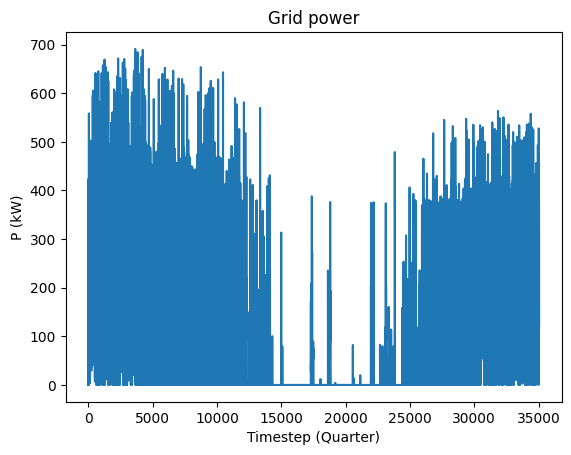

In [237]:
plt.figure(1)
plt.plot(np.divide(P_grid_reg,1000))
plt.title("Grid power")
plt.xlabel("Timestep (Quarter)")
plt.ylabel("P (kW)")
plt.show()

Battery

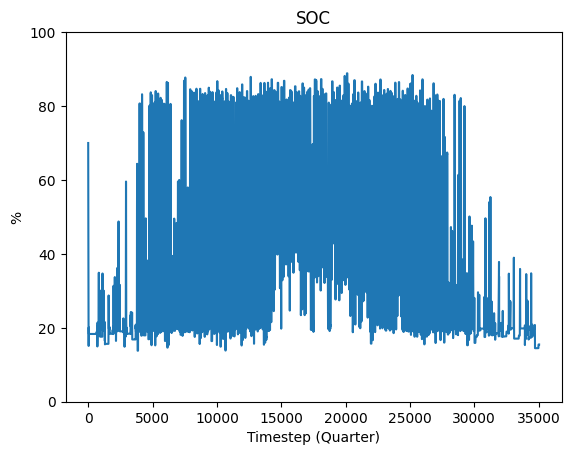

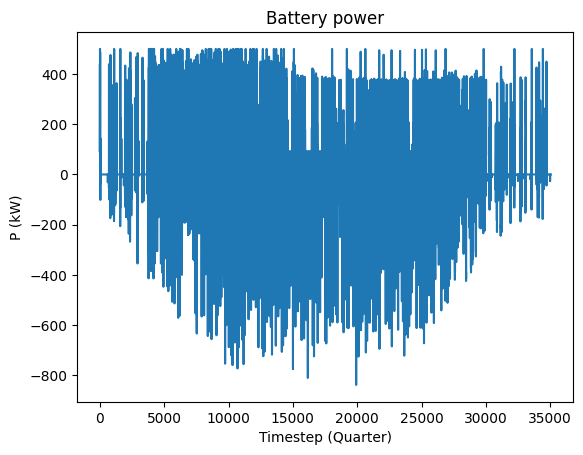

In [238]:
plt.figure(1)
plt.plot(SOC_battery_reg)                             # Plot in C
plt.title("SOC")
plt.xlabel("Timestep (Quarter)")
plt.ylabel("%")
plt.ylim([0,100])
plt.show()

plt.figure(1)
plt.plot(np.divide(P_battery_reg,1000))
plt.title("Battery power")
plt.xlabel("Timestep (Quarter)")
plt.ylabel("P (kW)")
plt.show()

HP extra

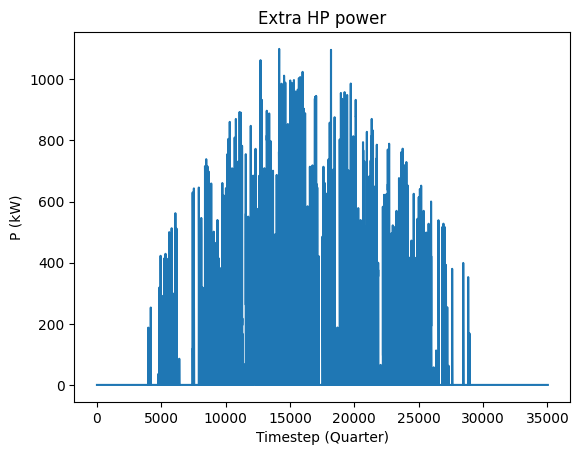

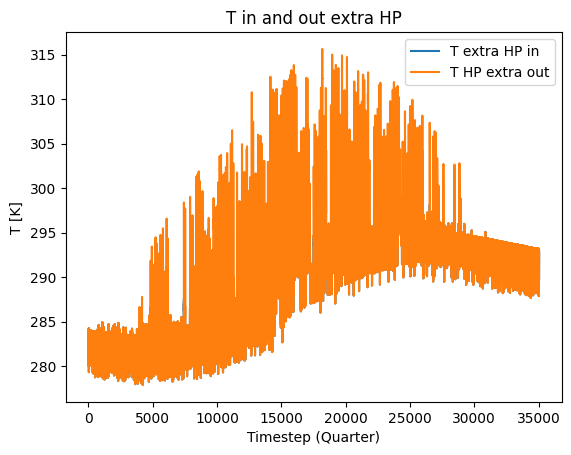

In [239]:
plt.figure(1)
plt.plot(np.divide(Php_X_reg,1000))
plt.title("Extra HP power")
plt.xlabel("Timestep (Quarter)")
plt.ylabel("P (kW)")
plt.show()

plt.figure(2)
plt.plot(T_network_reg[-1][:], label="T extra HP in")
plt.plot(T_hp_x_reg, label="T HP extra out")
plt.title("T in and out extra HP")
plt.xlabel("Timestep (Quarter)")
plt.ylabel("T [K]")
plt.legend()
plt.show()

Ambient Temperature (C)

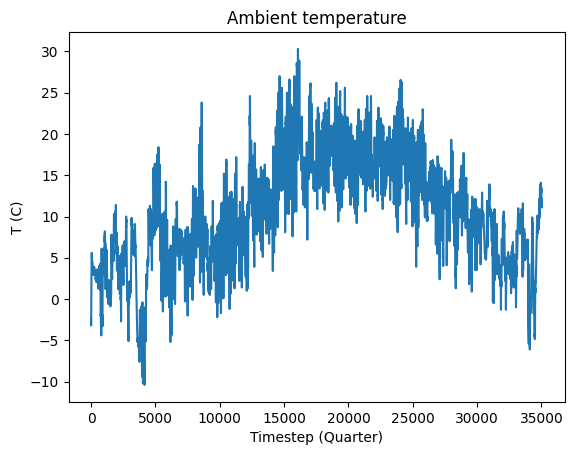

In [240]:
plt.figure(1)
plt.plot(np.subtract(T_amb[(startDay*96):(startDay*96)+finalStep],K))                             # Plot in C
plt.title("Ambient temperature")
plt.xlabel("Timestep (Quarter)")
plt.ylabel("T (C)")
plt.show()

Wind Speeds (m/s)

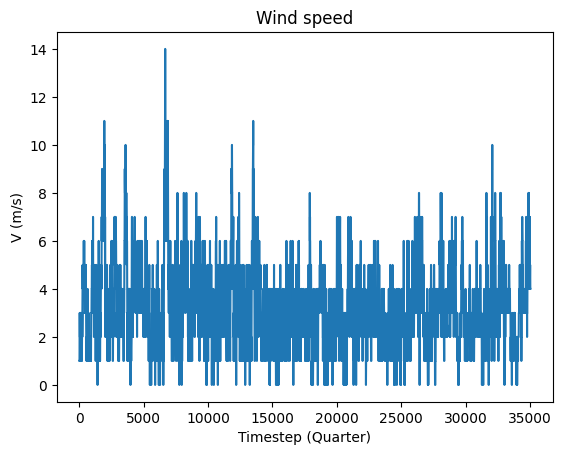

In [241]:
plt.figure(1)
plt.plot(V[(startDay*96):(startDay*96)+finalStep])
plt.title("Wind speed")
plt.xlabel("Timestep (Quarter)")
plt.ylabel("V (m/s)")
plt.show()

Irradiance (W/m^2)

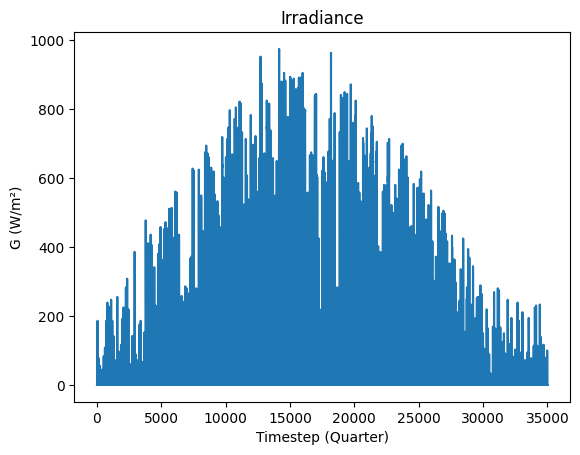

In [242]:
plt.figure(1)
plt.plot(G[(startDay*96):(startDay*96)+finalStep])
# plt.plot(G[0:96*700])
plt.title("Irradiance")
plt.xlabel("Timestep (Quarter)")
plt.ylabel("G (W/m\N{SUPERSCRIPT TWO})")
plt.show()

ATES

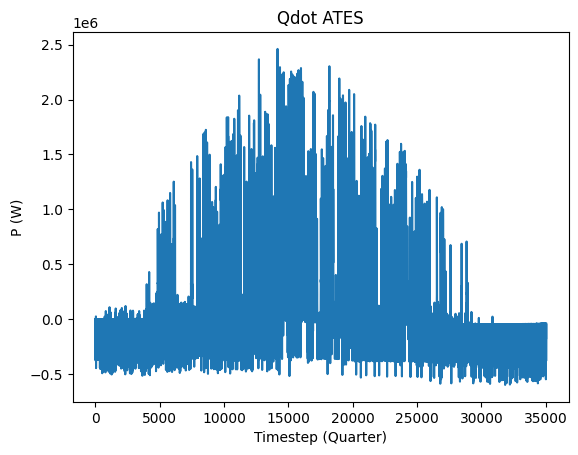

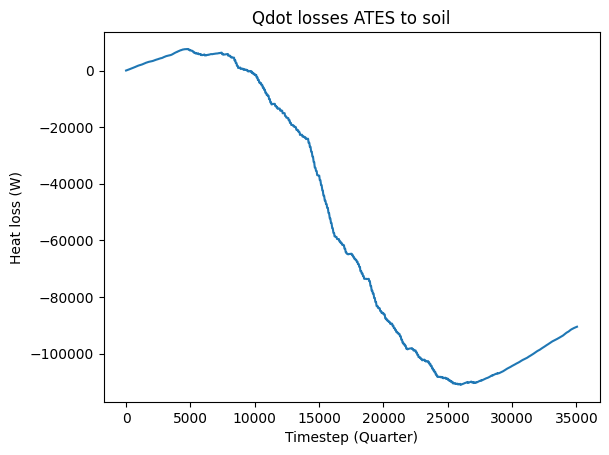

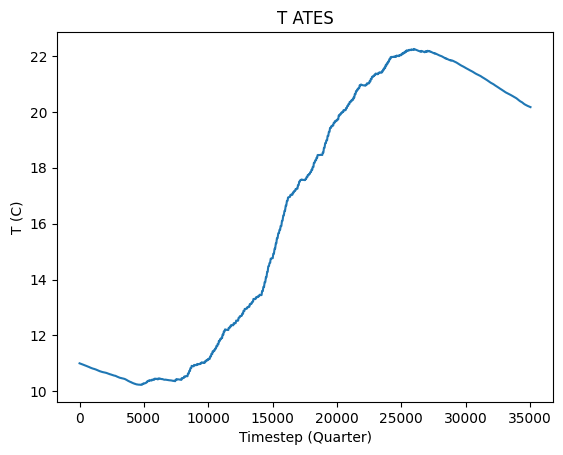

In [243]:
# # Constant for now
# plt.figure(4)
# plt.plot(P_pump_reg)                     
# plt.title("Aquifier pump Power")
# plt.xlabel("Timestep (Quarter)")
# plt.ylabel("P (kW)")
# plt.show()

plt.figure(3)
plt.plot(Qdot_ates_reg)            # Plot in W
plt.title("Qdot ATES")
plt.xlabel("Timestep (Quarter)")
plt.ylabel("P (W)")
plt.show()

plt.figure(2)
plt.plot(Qdot_ates_soil_reg)            # Plot in W
plt.title("Qdot losses ATES to soil")       # minus means losses
plt.xlabel("Timestep (Quarter)")
plt.ylabel("Heat loss (W)")
plt.show()

plt.figure(1)
plt.plot(np.subtract(T_ates_reg,K))                     # Plot in C
plt.title("T ATES")
plt.xlabel("Timestep (Quarter)")
plt.ylabel("T (C)")
plt.show()

Pipe 17

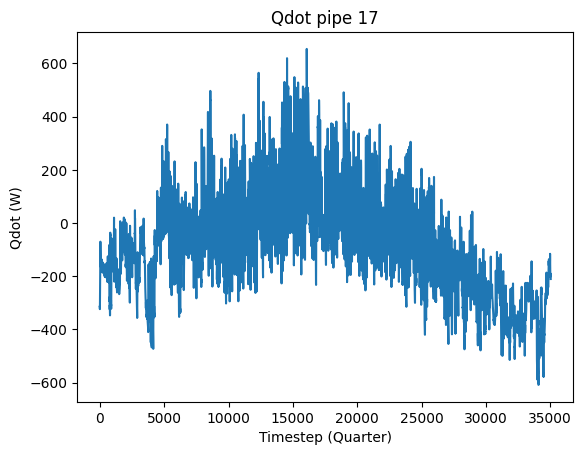

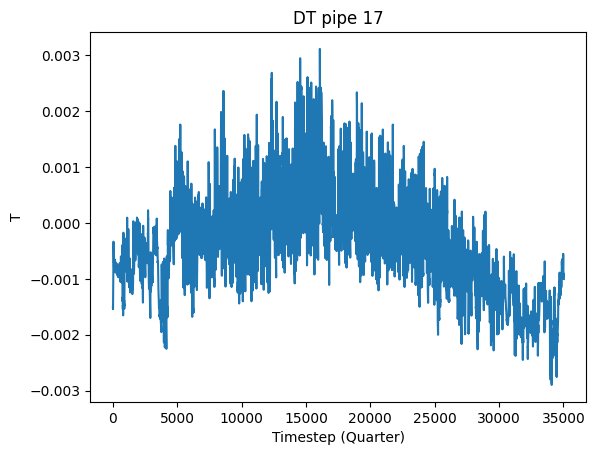

In [244]:
plt.figure(1)
plt.plot(Qdot_pipe17_reg)           # minus is losses
plt.title("Qdot pipe 17")
plt.xlabel("Timestep (Quarter)")
plt.ylabel("Qdot (W)")
plt.show()

plt.figure(1)
plt.plot(DT_pipe17_reg)    
plt.title("DT pipe 17")
plt.xlabel("Timestep (Quarter)")
plt.ylabel("T")
plt.show()



PVT system

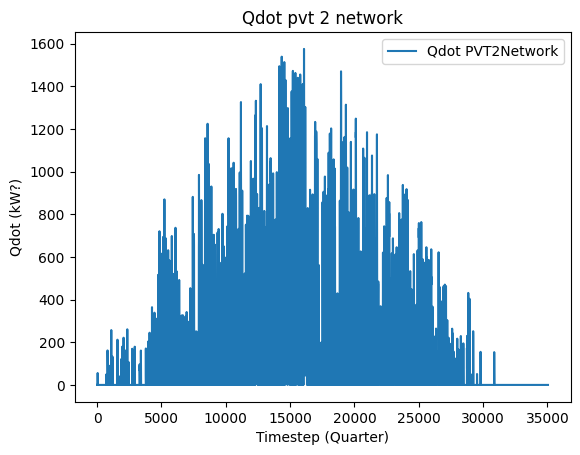

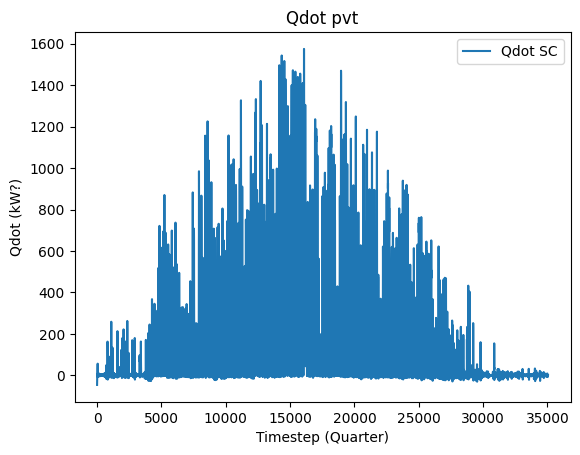

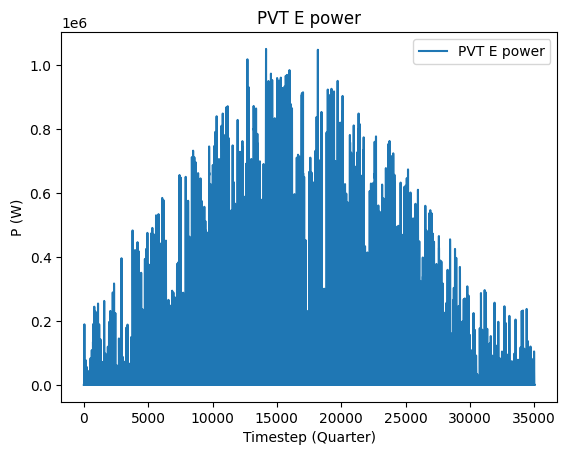

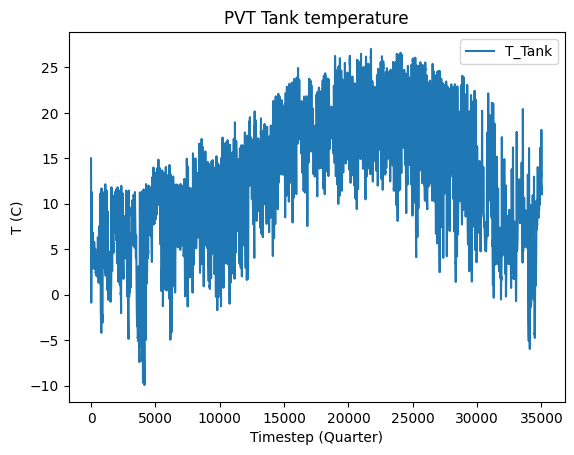

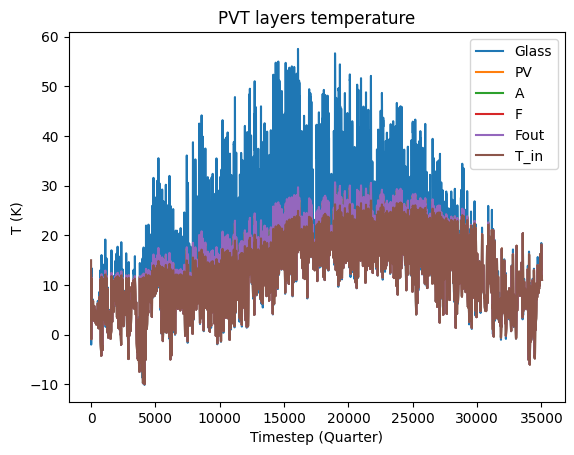

In [245]:
plt.figure(0)
plt.plot(np.divide(Qdot_PVT2Network_reg,1000), label="Qdot PVT2Network")                             # Plot in C
plt.title("Qdot pvt 2 network")
plt.xlabel("Timestep (Quarter)")
plt.ylabel("Qdot (kW?)")
plt.legend()
plt.show()


plt.figure(1)
plt.plot(np.divide(Qdot_SC_reg,1000), label="Qdot SC")                             # Plot in C
plt.title("Qdot pvt")
plt.xlabel("Timestep (Quarter)")
plt.ylabel("Qdot (kW?)")
plt.legend()
plt.show()


plt.figure(19)
plt.plot(P_pvt_reg, label="PVT E power")                             # Plot in C
plt.title("PVT E power")
plt.xlabel("Timestep (Quarter)")
plt.ylabel("P (W)")
plt.legend()
plt.show()

plt.figure(18)
plt.plot(np.subtract(T_tank_PVT_reg,K), label="T_Tank")                             # Plot in C
plt.title("PVT Tank temperature")
plt.xlabel("Timestep (Quarter)")
plt.ylabel("T (C)")
plt.legend()
plt.show()

plt.figure(17)
plt.plot(np.subtract(T_pvt_layers_reg[0],K), label="Glass") 
plt.plot(np.subtract(T_pvt_layers_reg[1],K), label="PV")
plt.plot(np.subtract(T_pvt_layers_reg[2],K), label="A") 
plt.plot(np.subtract(T_pvt_layers_reg[3],K), label="F")
plt.plot(np.subtract(T_pvt_layers_reg[4],K), label="Fout")     
plt.plot(np.subtract(T_tank_PVT_reg,K), label="T_in")                 
plt.title("PVT layers temperature")
plt.xlabel("Timestep (Quarter)")
plt.ylabel("T (K)")
plt.legend()
plt.show()



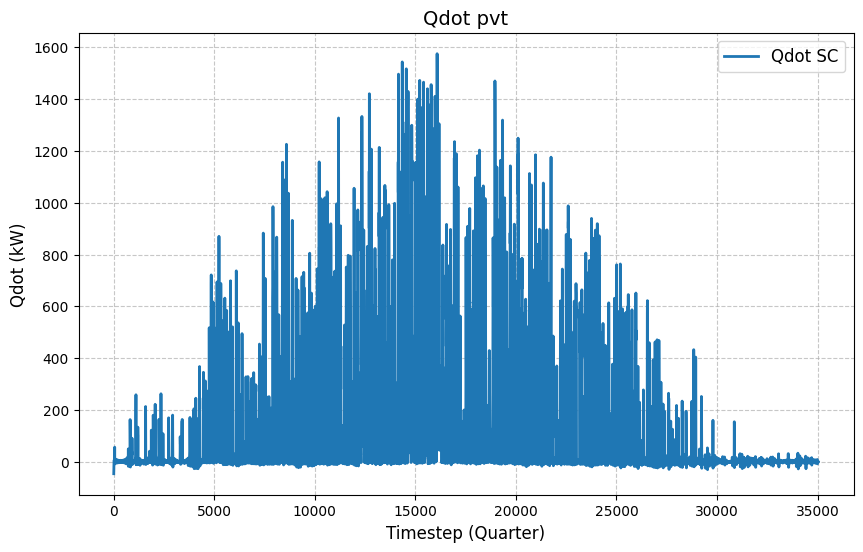

In [246]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))  # Adjust the figure size (width, height)
plt.plot(np.divide(Qdot_SC_reg, 1000), label="Qdot SC", linewidth=2)  # Increase line width for clarity
plt.title("Qdot pvt", fontsize=14)  # Increase title font size
plt.xlabel("Timestep (Quarter)", fontsize=12)  # Increase label font size
plt.ylabel("Qdot (kW)", fontsize=12)  # Increase label font size
plt.legend(fontsize=12)  # Increase legend font size
plt.grid(True, linestyle="--", alpha=0.7)  # Add a light grid for readability
plt.show()


Pipe 1

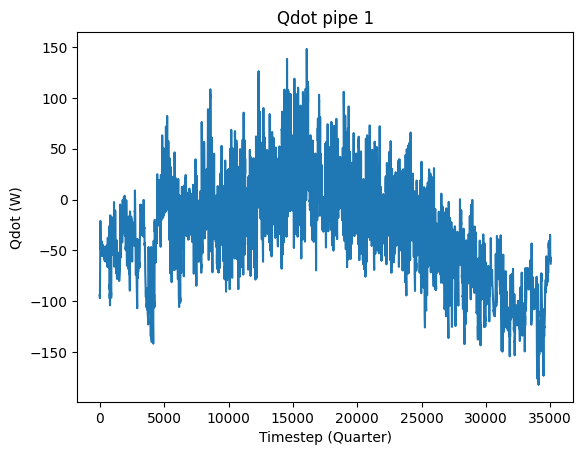

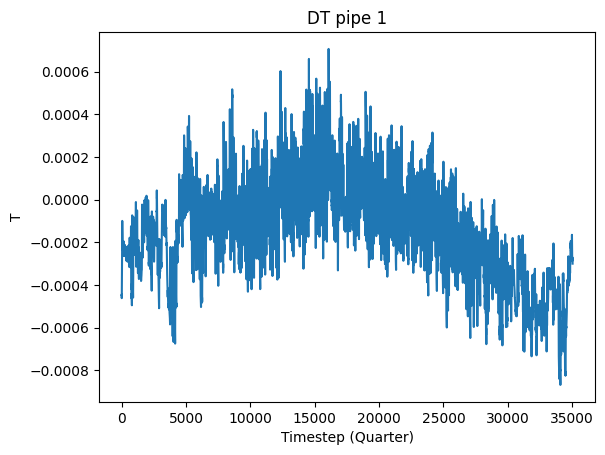

In [247]:
plt.figure(1)
plt.plot(Qdot_pipe1_reg)    
plt.title("Qdot pipe 1")
plt.xlabel("Timestep (Quarter)")
plt.ylabel("Qdot (W)")
plt.show()

plt.figure(2)
plt.plot(DT_pipe1_reg)    
plt.title("DT pipe 1")
plt.xlabel("Timestep (Quarter)")
plt.ylabel("T")
plt.show()

Thermal demand (Buildings)

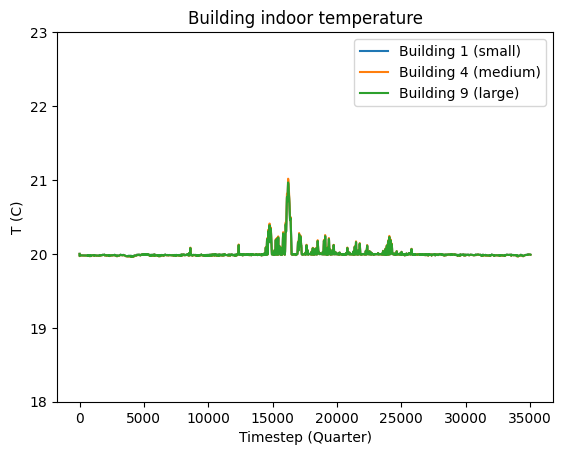

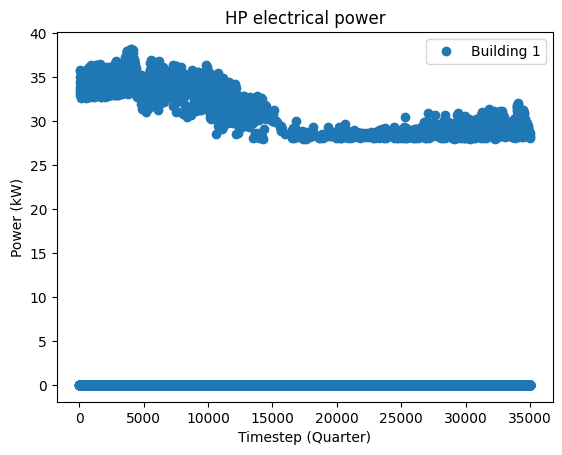

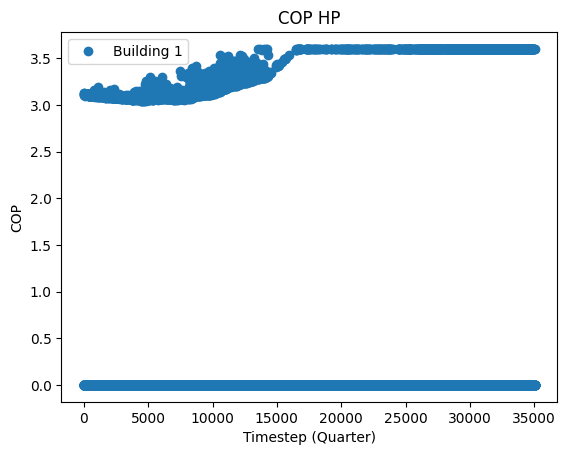

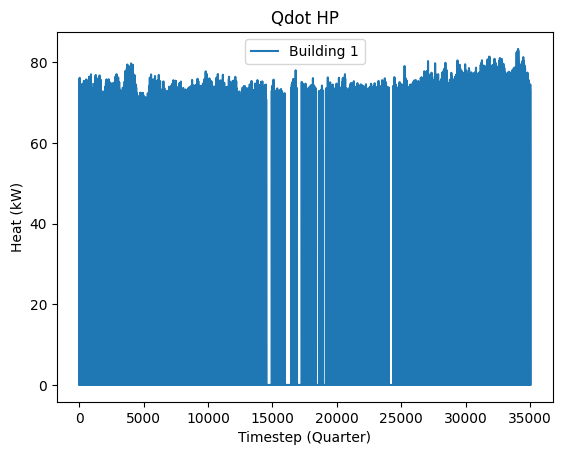

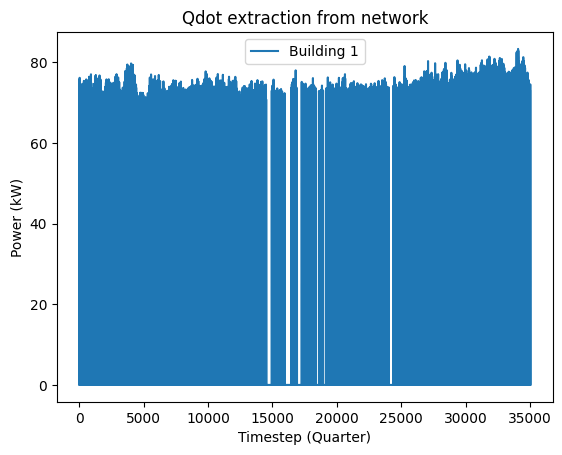

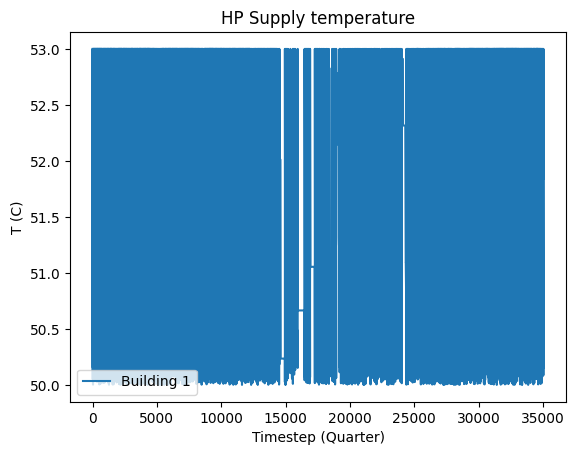

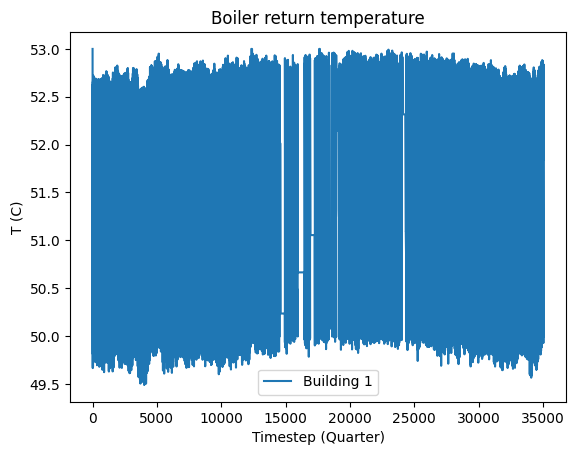

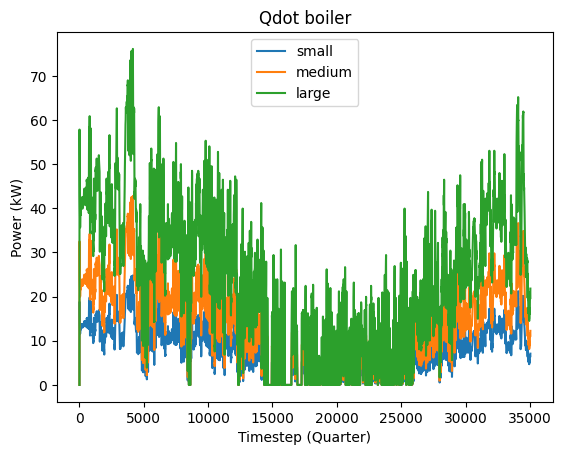

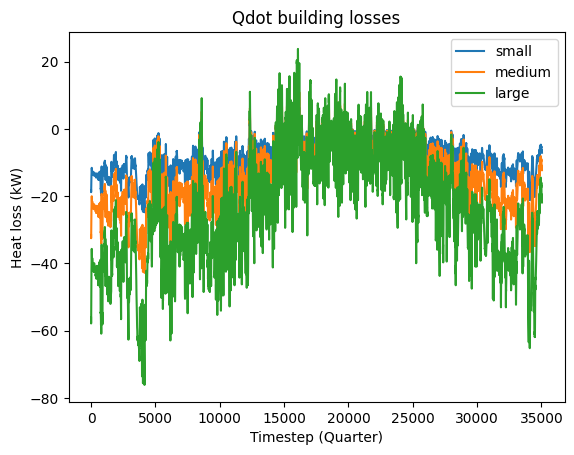

In [248]:
plt.figure(17)
plt.plot(np.subtract(T_in[0],K), label="Building 1 (small)")  
plt.plot(np.subtract(T_in[3],K), label="Building 4 (medium)")  
plt.plot(np.subtract(T_in[8],K), label="Building 9 (large)")                             # Plot in C
plt.title("Building indoor temperature")
plt.xlabel("Timestep (Quarter)")
plt.ylabel("T (C)")
plt.ylim([18,23])
plt.legend()
plt.show()

plt.figure(16)
plt.plot(np.divide(Php_reg[0],1000), 'o', label="Building 1")                             # Plot in C
plt.title("HP electrical power")
plt.xlabel("Timestep (Quarter)")
plt.ylabel("Power (kW)")
plt.legend()
plt.show()

plt.figure(15)
plt.plot(cop_HP_reg[0], 'o', label="Building 1")                             # Plot in C
plt.title("COP HP")
plt.xlabel("Timestep (Quarter)")
plt.ylabel("COP")
plt.legend()
plt.show()

plt.figure(14)
plt.plot(np.divide(Qdot_Network_reg[0],1000), label="Building 1")                             # Plot in C
plt.title("Qdot HP")
plt.xlabel("Timestep (Quarter)")
plt.ylabel("Heat (kW)")
plt.legend()
plt.show()

plt.figure(13)
plt.plot(np.divide(Qdot_Network_reg[0],1000), label="Building 1")                             # Plot in C
plt.title("Qdot extraction from network")
plt.xlabel("Timestep (Quarter)")
plt.ylabel("Power (kW)")
plt.legend()
plt.show()

plt.figure(12)
plt.plot(np.subtract(Tsup_reg[0],K), label="Building 1")                             # Plot in C
plt.title("HP Supply temperature")
plt.xlabel("Timestep (Quarter)")
plt.ylabel("T (C)")
plt.legend()
plt.show()

plt.figure(11)
plt.plot(np.subtract(Tret_reg[0],K), label="Building 1")                             # Plot in C
plt.title("Boiler return temperature")
plt.xlabel("Timestep (Quarter)")
plt.ylabel("T (C)")
plt.legend()
plt.show()

plt.figure(10)
plt.plot(np.divide(Qdot_B_reg[0],1000), label="small")   
plt.plot(np.divide(Qdot_B_reg[3],1000), label="medium") 
plt.plot(np.divide(Qdot_B_reg[8],1000), label="large")
plt.title("Qdot boiler")
plt.xlabel("Timestep (Quarter)")
plt.ylabel("Power (kW)")
plt.legend()
plt.show()

plt.figure(9)
plt.plot(np.divide(Qdot_D_reg[0],1000), label="small")   
plt.plot(np.divide(Qdot_D_reg[3],1000), label="medium") 
plt.plot(np.divide(Qdot_D_reg[8],1000), label="large")
plt.title("Qdot building losses")
plt.xlabel("Timestep (Quarter)")
plt.ylabel("Heat loss (kW)")
plt.legend()
plt.show()

Surface Temperature

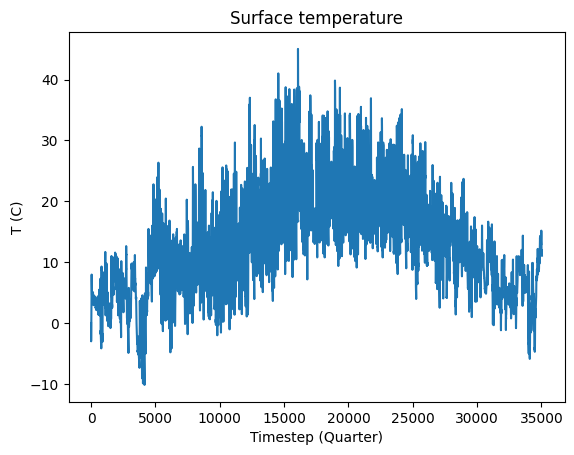

In [249]:







plt.figure(6)
plt.plot(np.subtract(T_surface_reg,K))                             # Plot in C
plt.title("Surface temperature")
plt.xlabel("Timestep (Quarter)")
plt.ylabel("T (C)")
plt.show()



Totals with CSV import

In [250]:
# Qdot_B_imp = np.loadtxt('ExportData/Qdot_B_reg_1y.csv', delimiter=';')  
# Qdot_SC_imp = np.loadtxt('ExportData/Qdot_PVT_1y.csv', delimiter=';')
# Qdot_PVT2Network_imp = np.loadtxt('ExportData/Qdot_PVT2Network_1y.csv', delimiter=';')

# Qdot_B_totalrow_1y = [item for sublist in Qdot_B_imp for item in sublist]

# QdotB_total = 0
# Qdot_SC_total = 0
# Qdot_PVT2Network_total = 0

# for item in range(len(Qdot_B_totalrow_1y)):
#     QdotB_total += Qdot_B_totalrow_1y[item]*0.25

# print("Building losses: " + str(QdotB_total/1000000))

# for item in range(len(Qdot_SC_imp)):
#     Qdot_SC_total += Qdot_SC_imp[item]*0.25

# print("PVT Generation: " + str(Qdot_SC_total/1000000))

# for item in range(len(Qdot_PVT2Network_imp)):
#     Qdot_PVT2Network_total += Qdot_PVT2Network_imp[item]*0.25

# print("PVT 2 Network: " + str(Qdot_PVT2Network_total/1000000))